In [1]:
# Modified from: https://twitter.com/balemkevin/status/1271084879518859267

import numpy as np
import pandas as pd
import xarray
from argopy import DataFetcher as ArgoDataFetcher

lon_min, lon_max = -136, -120
lat_min, lat_max = 41.78, 52.24


argo_loader = ArgoDataFetcher(cache=False)

surface = 0, 10
deep = 975, 1025
time_span = "2009-12", "2020-01"

df1 = argo_loader.region(
    [lon_min, lon_max, lat_min, lat_max, *surface, *time_span]
).to_xarray()
df2 = argo_loader.region(
    [lon_min, lon_max, lat_min, lat_max, *deep, *time_span]
).to_xarray()

In [2]:
# weeks
daterange = np.arange("2010-01-01", "2020-01-03", dtype="datetime64[7D]")

# middle of the week
dayoftheyear = pd.DatetimeIndex(
    np.array(daterange, dtype="datetime64[D]") + 3
).dayofyear
activeyear = pd.DatetimeIndex(np.array(daterange, dtype="datetime64[D]") + 3).year

tsurf = np.zeros(len(daterange))
t1000 = np.zeros(len(daterange))

for k in range(len(daterange)):
    i1 = (df1["TIME"] >= daterange[k]) & (df1["TIME"] < daterange[k] + 7)
    i2 = (df2["TIME"] >= daterange[k]) & (df2["TIME"] < daterange[k] + 7)
    tsurf[k] = df1.where(i1, drop=True)["TEMP"].mean().values
    t1000[k] = df2.where(i2, drop=True)["TEMP"].mean().values

d = {"date": np.array(daterange, dtype="datetime64[D]"), "tsurf": tsurf, "t1000": t1000}
ndf = pd.DataFrame(data=d)
ndf.head()

,date,tsurf,t1000
0,2009-12-31,9.428312,3.396316
1,2010-01-07,9.437174,3.392417
2,2010-01-14,9.307743,3.384987
3,2010-01-21,9.224073,3.394181
4,2010-01-28,9.196264,3.388028


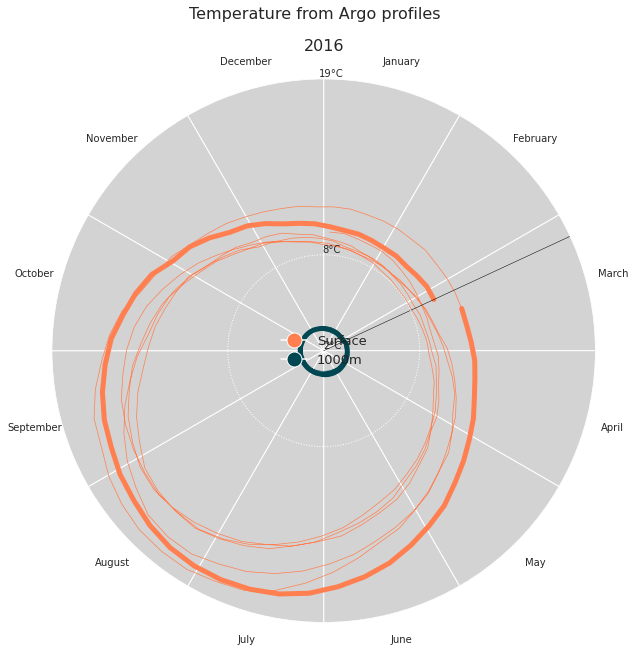

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["xtick.major.pad"] = "17"
plt.rcParams["axes.axisbelow"] = False
matplotlib.rc("axes", edgecolor="w")
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

big_angle = 360 / 12
date_angle = ((360 / 365) * dayoftheyear) * np.pi / 180
inner = 2
outer = 19
ocean_color = ["#ff7f50", "#004752"]


def dress_axes(ax):
    ax.set_facecolor("w")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    middles = np.arange(big_angle / 2, 360, big_angle) * np.pi / 180
    ax.set_xticks(middles)
    ax.set_xticklabels(
        [
            "January",
            "February",
            "March",
            "April",
            "May",
            "June",
            "July",
            "August",
            "September",
            "October",
            "November",
            "December",
        ]
    )
    ax.set_yticks([2, 8, 19])
    ax.set_yticklabels(["2°C", "8°C", "19°C"])
    ax.set_rlabel_position(359)
    ax.tick_params(axis="both", color="w")
    plt.grid(None, axis="x")
    plt.grid(axis="y", color="w", linestyle=":", linewidth=1)
    bars = ax.bar(
        middles,
        outer,
        width=big_angle * np.pi / 180,
        bottom=inner,
        color="lightgray",
        edgecolor="w",
        zorder=0,
    )
    plt.ylim([2, outer])
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Surface",
            markerfacecolor=ocean_color[0],
            markersize=15,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="1000m",
            markerfacecolor=ocean_color[1],
            markersize=15,
        ),
    ]
    ax.legend(handles=legend_elements, loc="center", fontsize=13, frameon=False)
    plt.suptitle(
        "Temperature from Argo profiles", fontsize=16, horizontalalignment="center"
    )


def update(i):
    ax.cla()
    dress_axes(ax)
    i0 = np.max([i - 51, 0])

    ax.plot(
        date_angle[i0 : i + 1],
        ndf["tsurf"][i0 : i + 1],
        "-",
        color=ocean_color[0],
        alpha=1.0,
        linewidth=5,
    )
    ax.plot(
        date_angle[0 : i + 1],
        ndf["tsurf"][0 : i + 1],
        "-",
        color=ocean_color[0],
        linewidth=0.7,
    )

    ax.plot(
        date_angle[i0 : i + 1],
        ndf["t1000"][i0 : i + 1],
        "-",
        color=ocean_color[1],
        alpha=1.0,
        linewidth=5,
    )
    ax.plot(
        date_angle[0 : i + 1],
        ndf["t1000"][0 : i + 1],
        "-",
        color=ocean_color[1],
        linewidth=0.7,
    )

    ax.plot([date_angle[i], date_angle[i]], [inner, outer], "k-", linewidth=0.5)
    plt.title(str(activeyear[i]), fontsize=16, horizontalalignment="center")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

dress_axes(ax)
update(322)

In [4]:
anim = FuncAnimation(fig, update, interval=40, frames=len(daterange) - 1, repeat=False)

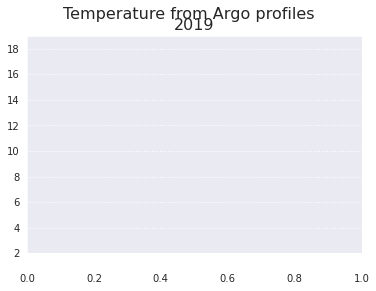

In [5]:
HTML(anim.to_html5_video())